# NCAA ML Model

In [2]:
from __future__ import print_function
import numpy as np
import pandas as pd
import csv
import sys
import os
from sklearn import svm
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
# %matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.linear_model import LogisticRegression

## Goals

Given the regular season game data predict the champion for the NCAA tournament this season

## Define the problem

Taking raw dataset from past games and predict a winner and take into account  that upsets do happen often in tournaments

According to Breakthrough Basketball, the most important statistics that affect the strength of a college basketball team and the outcome of their future games are: the assist-to-turnover ratio, free throw accuracy percentage, and field goal accuracy percentage. We chose to use all three of these as features in our model to predict the strongest teams going into the NCAA postseason men's basketball tournament so that we might predict the eventual winner. We also chose to include such features as each team's designated seed in the tournament, the location of the game played (whether it will be played at home, away, or on a neutral court), and the total points scored by each team in the regular season. Thus, given regular season game data for all teams in the tournament, we will attempt to predict who will emerge the winner. 


https://www.breakthroughbasketball.com/stats/how-we-use-stats-Hagness.html

## Import Dataset

In [3]:
label_path = "./data/MNCAATourneyCompactResults.csv"
input_path = "./data/MRegularSeasonDetailedResults.csv"
team_id_path = "./data/MTeams.csv"
seed_path = "./data/MNCAATourneySeeds.csv"
label_df = pd.read_csv(label_path)
input_df = pd.read_csv(input_path)
team_df = pd.read_csv(team_id_path)
seed_df = pd.read_csv(seed_path)
df = pd.concat([input_df],axis=1)
pd.set_option('display.max_rows', None)
df.head().transpose()

,0,1,2,3,4
Season,2003,2003,2003,2003,2003
DayNum,10,10,11,11,11
WTeamID,1104,1272,1266,1296,1400
WScore,68,70,73,56,77
LTeamID,1328,1393,1437,1457,1208
LScore,62,63,61,50,71
WLoc,N,N,N,N,N
NumOT,0,0,0,0,0
WFGM,27,26,24,18,30
WFGA,58,62,58,38,61


## Feature Selection

In [4]:
# finding y label
label_map = {}
for index, row in label_df.iterrows():
    if row["DayNum"] == 154:
        label_map[row["Season"]] = row["WTeamID"]
WisWinner = []
LisWinner = []
for index, row in df.iterrows():
    if row["WTeamID"] == label_map[row["Season"]]:
        WisWinner.append(1)
    else:
        WisWinner.append(0)
    if row["LTeamID"] == label_map[row["Season"]]:
        LisWinner.append(1)
    else:
        LisWinner.append(0)
tmp = pd.DataFrame({"WisWinner": WisWinner,
                   "LisWinner" : LisWinner})
df = pd.concat([df,tmp],axis = 1)

In [5]:
features = ["Season","WTeamID","LTeamID","WScore","LScore","WLoc","WFTA","LFTA","WFTM","LFTM","WFGM","WFGA","LFGM","LFGA","WAst","LAst","WTO","LTO","WisWinner","LisWinner"]
new_df = df[features]
# The inputs
new_df.transpose()


,0,1,2,3,4,5,6,7,8,9,...,87494,87495,87496,87497,87498,87499,87500,87501,87502,87503
Season,2003,2003,2003,2003,2003,2003,2003,2003,2003,2003,...,2019,2019,2019,2019,2019,2019,2019,2019,2019,2019
WTeamID,1104,1272,1266,1296,1400,1458,1161,1186,1194,1458,...,1429,1436,1437,1463,1120,1153,1209,1277,1387,1463
LTeamID,1328,1393,1437,1457,1208,1186,1236,1457,1156,1296,...,1361,1420,1371,1343,1397,1222,1426,1276,1382,1217
WScore,68,70,73,56,77,81,80,75,71,84,...,64,66,74,83,84,69,73,65,55,97
LScore,62,63,61,50,71,55,62,61,66,56,...,57,49,72,77,64,57,64,60,53,85
WLoc,N,N,N,N,N,H,H,N,N,H,...,N,H,N,H,N,N,N,N,N,H
WFTA,18,19,29,31,13,27,39,21,18,19,...,24,23,26,16,21,25,34,16,15,30
LFTA,22,20,23,15,27,17,28,23,27,12,...,12,14,11,20,13,18,17,12,10,24
WFTM,11,10,17,17,11,23,32,15,10,15,...,17,17,19,16,17,19,25,12,7,28
LFTM,16,9,14,8,17,12,20,17,12,7,...,8,11,9,15,10,11,11,10,8,19


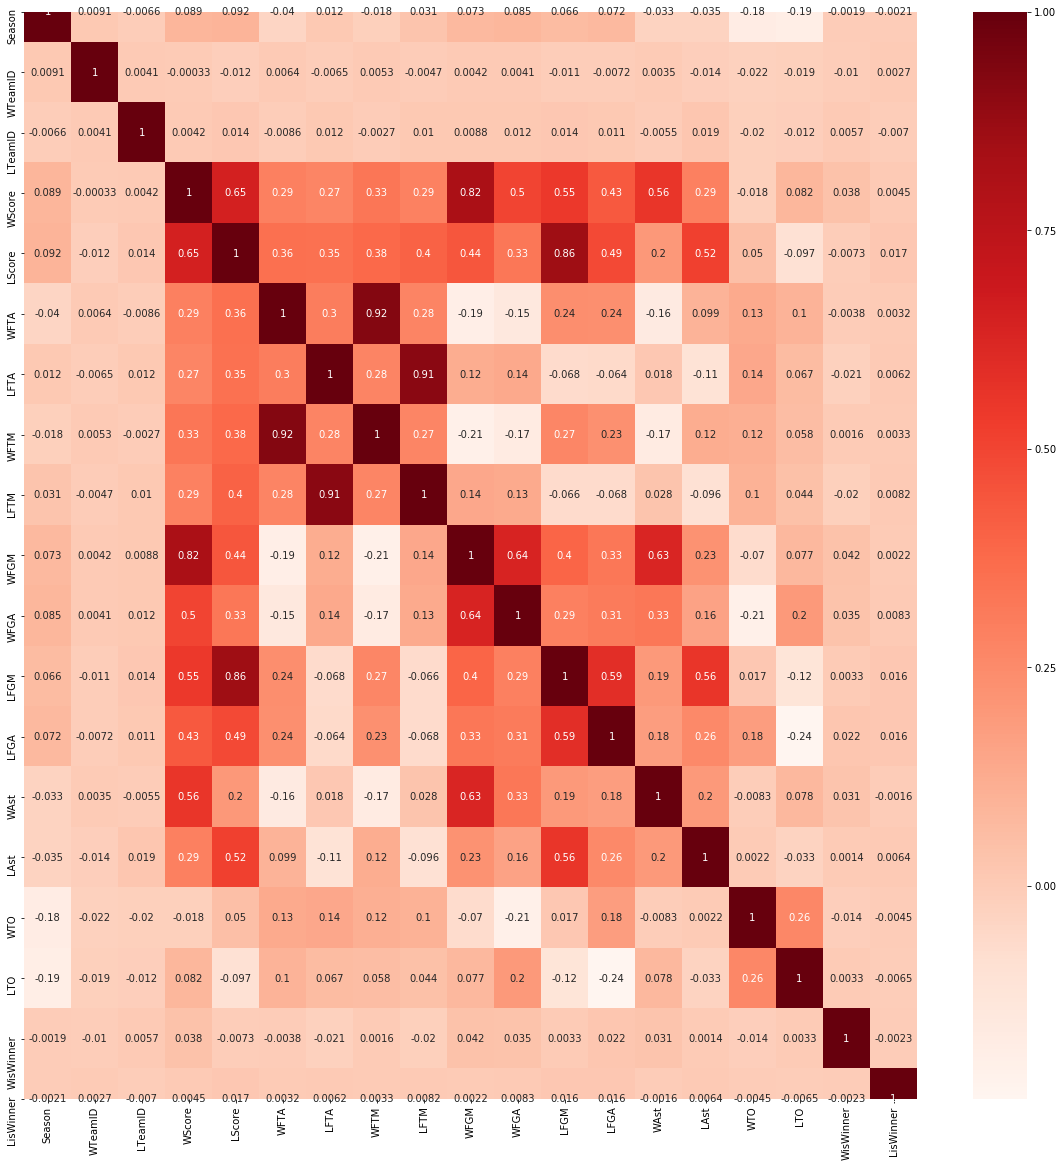

In [6]:
plt.figure(figsize=(20,20))
cor = new_df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

## Transform Data

In [7]:
# getting seed to match their WTeamID or LTeamID
seed_df.head().transpose()
WSeeds = []
LSeeds = []

WAstTORatios = []
LAstTORatios = []

WFTRatios = []
LFTRatios = []

WFGRatios = []
LFGRatios = []

for index, row in new_df.iterrows():
    Wquery = "Season == {} and TeamID == {}".format(str(row['Season']),str(row["WTeamID"]))
    Lquery = "Season == {} and TeamID == {}".format(str(row['Season']),str(row["LTeamID"]))
    Wseed = seed_df.query(Wquery)["Seed"].values
    Lseed = seed_df.query(Lquery)["Seed"].values
    
    Wseed = Wseed[0] if len(Wseed) > 0 else 0
    Lseed = Lseed[0] if len(Lseed) > 0 else 0
    
    WSeeds.append(Wseed)
    LSeeds.append(Lseed)

    WAst = row["WAst"]
    LAst = row["LAst"]
    WTO = row["WTO"]
    LTO = row["LTO"]
    WTO += 0.1
    LTO += 0.1
    WAstTORatio = WAst/WTO 
    LAstTORatio = LAst/LTO 

    WAstTORatios.append(WAstTORatio)
    LAstTORatios.append(LAstTORatio)
        
    WFGA = row["WFGA"]
    WFGM = row["WFGM"]
    LFGA = row["LFGA"]
    LFGM = row["LFGM"]
    if WFGA == 0:
        WFGRatios.append(0)
    else:
        WFGRatios.append(WFGM/WFGA)

    if LFGA == 0:
        LFGRatios.append(0)
    else:
        LFGRatios.append(LFGM/LFGA)
    
    WFTA = row["WFTA"]
    WFTM = row["WFTM"]
    LFTA = row["LFTA"]
    LFTM= row["LFTM"]
    if WFTA == 0:
        WFTRatios.append(0)
    else:
        WFTRatios.append(WFTM/WFTA)

    if LFTA == 0:
        LFTRatios.append(0)
    else:
        LFTRatios.append(LFTM/LFTA)
new_df.shape

(87504, 20)

In [8]:
# new_df = new_df.assign(WSeed = WSeeds)
# new_df = new_df.assign(LSeed = LSeeds)
temp_df = pd.DataFrame({
"WSeeds" : WSeeds,
"LSeeds" : LSeeds,
"WAstTORatios" : WAstTORatios,
"LAstTORatios" : LAstTORatios,
"WFTRatios" : WFTRatios,
"LFTRatios" : LFTRatios,
"WFGRatios" : WFGRatios,
"LFGRatios" : LFGRatios
})
new_df = pd.concat([new_df,temp_df],axis = 1)
new_df.head().transpose()

,0,1,2,3,4
Season,2003,2003,2003,2003,2003
WTeamID,1104,1272,1266,1296,1400
LTeamID,1328,1393,1437,1457,1208
WScore,68,70,73,56,77
LScore,62,63,61,50,71
WLoc,N,N,N,N,N
WFTA,18,19,29,31,13
LFTA,22,20,23,15,27
WFTM,11,10,17,17,11
LFTM,16,9,14,8,17


In [9]:
# dropping columns
new_df = new_df.drop(["WAst","LAst","WFTM","LFTM","WFTA","LFTA","WFGA","LFGA","WFGM","LFGM","WTO","LTO"], axis = 1)

In [10]:
new_df.tail().transpose()

,87499,87500,87501,87502,87503
Season,2019,2019,2019,2019,2019
WTeamID,1153,1209,1277,1387,1463
LTeamID,1222,1426,1276,1382,1217
WScore,69,73,65,55,97
LScore,57,64,60,53,85
WLoc,N,N,N,N,H
WisWinner,0,0,0,0,0
LisWinner,0,0,0,0,0
WSeeds,Z07,Y14,W02,W13,W14
LSeeds,Y03,0,X02,0,0


## Model definition

In [11]:
# merging all teams into one dataset
Merge_Season = []
Merge_TeamID = []
Merge_Score = []
Merge_Loc = []
Merge_isWinner = []
Merge_Seeds = []
Merge_AstTORatios = []
Merge_FTRatios = []
Merge_FGRatios = []
i = 0;
while i < new_df['Season'].count():
    #add winning team stats
    Merge_Season.append(new_df.at[i,'Season'])
    Merge_TeamID.append(new_df.at[i,'WTeamID'])
    Merge_Score.append(new_df.at[i,'WScore'])
    Merge_Loc.append(new_df.at[i,'WLoc'])
    Merge_isWinner.append(1)
    Merge_Seeds.append(new_df.at[i,'WSeeds'])
    Merge_AstTORatios.append(new_df.at[i,'WAstTORatios'])
    Merge_FTRatios.append(new_df.at[i,'WFTRatios'])
    Merge_FGRatios.append(new_df.at[i,'WFGRatios'])
    
    #add losing team stats
    Merge_Season.append(new_df.at[i,'Season'])
    Merge_TeamID.append(new_df.at[i,'LTeamID'])
    Merge_Score.append(new_df.at[i,'LScore'])
    temp_loc = ''
    if new_df.at[i,'WLoc'] == 'H':
        temp_loc = 'A'
    if new_df.at[i,'WLoc'] == 'N':
        temp_loc = 'N'
    if new_df.at[i,'WLoc'] == 'A':
        temp_loc = 'H'
    Merge_Loc.append(temp_loc)
    Merge_isWinner.append(0)
    Merge_Seeds.append(new_df.at[i,'LSeeds'])
    Merge_AstTORatios.append(new_df.at[i,'LAstTORatios'])
    Merge_FTRatios.append(new_df.at[i,'LFTRatios'])
    Merge_FGRatios.append(new_df.at[i,'LFGRatios'])
    i = i + 1
merge_df = pd.DataFrame({"Season": Merge_Season,
                        "TeamID" : Merge_TeamID,
                        "Score" : Merge_Score,
                        "Loc" : Merge_Loc,
                        "IsWinner" : Merge_isWinner,
                        "Seeds" : Merge_Seeds,
                        "AstTORatios" : Merge_AstTORatios,
                        "FTRatios" : Merge_FTRatios,
                        "FGRatios" : Merge_FGRatios})
merge_df.transpose()

,0,1,2,3,4,5,6,7,8,9,...,174998,174999,175000,175001,175002,175003,175004,175005,175006,175007
Season,2003,2003,2003,2003,2003,2003,2003,2003,2003,2003,...,2019,2019,2019,2019,2019,2019,2019,2019,2019,2019
TeamID,1104,1328,1272,1393,1266,1437,1296,1457,1400,1208,...,1153,1222,1209,1426,1277,1276,1387,1382,1463,1217
Score,68,62,70,63,73,61,56,50,77,71,...,69,57,73,64,65,60,55,53,97,85
Loc,N,N,N,N,N,N,N,N,N,N,...,N,N,N,N,N,N,N,N,H,A
IsWinner,1,0,1,0,1,0,1,0,1,0,...,1,0,1,0,1,0,1,0,1,0
Seeds,Y10,W01,Z07,W03,Y03,0,0,0,X01,0,...,Z07,Y03,Y14,0,W02,X02,W13,0,W14,0
AstTORatios,0.562771,0.441989,1.22137,0.578512,1.48515,0.743802,0.909091,0.471204,0.851064,1.18812,...,0.540541,1.12676,0.792079,0.851064,1.53846,2.78689,2.13115,0.810811,1.5493,0.769231
FTRatios,0.611111,0.727273,0.526316,0.45,0.586207,0.608696,0.548387,0.533333,0.846154,0.62963,...,0.76,0.611111,0.735294,0.647059,0.75,0.833333,0.466667,0.8,0.933333,0.791667
FGRatios,0.465517,0.415094,0.419355,0.358209,0.413793,0.30137,0.473684,0.367347,0.491803,0.387097,...,0.44,0.306452,0.4,0.359375,0.4,0.411765,0.372881,0.339286,0.603774,0.451613


In [33]:
raw_df = merge_df.copy()
raw_df = raw_df.drop(["Season","Loc","IsWinner","TeamID","Seeds"], axis = 1)
results_df = merge_df.copy()
results_df = results_df["IsWinner"]



df_2003 = raw_df[0:9232].copy()
df_2004 = raw_df[9233:18374].copy()
df_2005 = raw_df[18375:27724].copy()
df_2006 = raw_df[27725:37238].copy()
df_2007 = raw_df[37239:47324].copy()
df_2008 = raw_df[47325:57650].copy()
df_2009 = raw_df[57651:68148].copy()
df_2010 = raw_df[68149:78674].copy()
df_2011 = raw_df[78675:89166].copy()
df_2012 = raw_df[89167:99672].copy()
df_2013 = raw_df[99673:110312].copy()
df_2014 = raw_df[110313:121036].copy()
df_2015 = raw_df[121037:131744].copy()
df_2016 = raw_df[131745:142482].copy()
df_2017 = raw_df[142483:153272].copy()
df_2018 = raw_df[153273:164082].copy()
df_2019 = raw_df[164083:175008].copy()

teams = []
average_Score = []
average_AstTORatios = []
average_FTRatios = []
average_FGRatios = []
counts = []
i = 0
while i < merge_df['AstTORatios'].count():
    j = 0
    data_placed = False
    for j in range(0,len(teams)):
        if merge_df.at[i, 'TeamID'] == teams[j]:
            average_AstTORatios[j] = average_AstTORatios[j] + merge_df.at[i,'AstTORatios']
            average_FTRatios[j] = average_FTRatios[j] + merge_df.at[i,'FTRatios']
            average_FGRatios[j] = average_FGRatios[j] + merge_df.at[i,'FGRatios']
            average_Score[j] = average_Score[j] + merge_df.at[i,'Score']
            counts[j] = counts[j] + 1
            data_placed = True
    if data_placed == False:
        teams.append(merge_df.at[i,'TeamID'])
        average_AstTORatios.append(merge_df.at[i,'AstTORatios'])
        average_FTRatios.append(merge_df.at[i,'FTRatios'])
        average_FGRatios.append(merge_df.at[i,'FGRatios'])
        average_Score.append(merge_df.at[i,'Score'])
        counts.append(1)
    i = i + 1
        

wdf_2003 = results_df[0:9232].copy()
wdf_2004 = results_df[9233:18374].copy()
wdf_2005 = results_df[18375:27724].copy()
wdf_2006 = results_df[27725:37238].copy()
wdf_2007 = results_df[37239:47324].copy()
wdf_2008 = results_df[47325:57650].copy()
wdf_2009 = results_df[57651:68148].copy()
wdf_2010 = results_df[68149:78674].copy()
wdf_2011 = results_df[78675:89166].copy()
wdf_2012 = results_df[89167:99672].copy()
wdf_2013 = results_df[99673:110312].copy()
wdf_2014 = results_df[110313:121036].copy()
wdf_2015 = results_df[121037:131744].copy()
wdf_2016 = results_df[131745:142482].copy()
wdf_2017 = results_df[142483:153272].copy()
wdf_2018 = results_df[153273:164082].copy()
wdf_2019 = results_df[164083:175008].copy()

In [34]:
j = 0
for j in range(0,len(teams)):
    average_AstTORatios[j] = average_AstTORatios[j] / counts[j]
    average_FTRatios[j] = average_FTRatios[j] / counts[j]
    average_FGRatios[j] = average_FGRatios[j] / counts[j]
    average_Score[j] = average_Score[j] / counts[j]
    
team_df = pd.DataFrame({"Score" : average_Score,
                        "AstTORatios" : average_AstTORatios,
                        "FTRatios" : average_FTRatios,
                        "FGRatios" : average_FGRatios})

In [35]:
reg = ["","","","","","","","","","","","","","","",""]
reg[0] = reg2003 = LogisticRegression(random_state=0).fit(df_2003,wdf_2003.transpose())
reg[1] = reg2004 = LogisticRegression(random_state=0).fit(df_2004,wdf_2004.transpose())
reg[2] = reg2005 = LogisticRegression(random_state=0).fit(df_2005,wdf_2005.transpose())
reg[3] = reg2006 = LogisticRegression(random_state=0).fit(df_2006,wdf_2006.transpose())
reg[4] = reg2007 = LogisticRegression(random_state=0).fit(df_2007,wdf_2007.transpose())
reg[5] = reg2008 = LogisticRegression(random_state=0).fit(df_2008,wdf_2008.transpose())
reg[6] = reg2009 = LogisticRegression(random_state=0).fit(df_2009,wdf_2009.transpose())
reg[7] = reg2010 = LogisticRegression(random_state=0).fit(df_2010,wdf_2010.transpose())
reg[8] = reg2011 = LogisticRegression(random_state=0).fit(df_2011,wdf_2011.transpose())
reg[9] = reg2012 = LogisticRegression(random_state=0).fit(df_2012,wdf_2012.transpose())
reg[10] = reg2013 = LogisticRegression(random_state=0).fit(df_2013,wdf_2013.transpose())
reg[11] = reg2014 = LogisticRegression(random_state=0).fit(df_2014,wdf_2014.transpose())
reg[12] = reg2015 = LogisticRegression(random_state=0).fit(df_2015,wdf_2015.transpose())
reg[13] = reg2016 = LogisticRegression(random_state=0).fit(df_2016,wdf_2016.transpose())
reg[14] = reg2017 = LogisticRegression(random_state=0).fit(df_2017,wdf_2017.transpose())
reg[15] = reg2018 = LogisticRegression(random_state=0).fit(df_2018,wdf_2018.transpose())

C:\Users\Luke\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Luke\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Luke\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Luke\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Luke\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this w

## Trainning

In [36]:
errors = ["","","","","","","","","","","","","","","",""]
#2003 validation
diff2003 = ["","","","","","","","","","","","","","",""]
diff2003[0] = reg2003.predict(df_2004) - wdf_2004
diff2003[1] = reg2003.predict(df_2005) - wdf_2005
diff2003[2] = reg2003.predict(df_2006) - wdf_2006
diff2003[3] = reg2003.predict(df_2007) - wdf_2007
diff2003[4] = reg2003.predict(df_2008) - wdf_2008
diff2003[5] = reg2003.predict(df_2009) - wdf_2009
diff2003[6] = reg2003.predict(df_2010) - wdf_2010
diff2003[7] = reg2003.predict(df_2011) - wdf_2011
diff2003[8] = reg2003.predict(df_2012) - wdf_2012
diff2003[9] = reg2003.predict(df_2013) - wdf_2013
diff2003[10] = reg2003.predict(df_2014) - wdf_2014
diff2003[11] = reg2003.predict(df_2015) - wdf_2015
diff2003[12] = reg2003.predict(df_2016) - wdf_2016
diff2003[13] = reg2003.predict(df_2017) - wdf_2017
diff2003[14] = reg2003.predict(df_2018) - wdf_2018
diff2003size = 0
diff2003errors = 0
for i in range(0,15):
    diff2003size += diff2003[i].size
    diff2003errors += diff2003[i].abs().sum()
error2003 = diff2003errors/diff2003size
errors[0] = error2003

In [37]:
#2004 validation
diff2004 = ["","","","","","","","","","","","","","",""]
diff2004[0] = reg2004.predict(df_2003) - wdf_2003
diff2004[1] = reg2004.predict(df_2005) - wdf_2005
diff2004[2] = reg2004.predict(df_2006) - wdf_2006
diff2004[3] = reg2004.predict(df_2007) - wdf_2007
diff2004[4] = reg2004.predict(df_2008) - wdf_2008
diff2004[5] = reg2004.predict(df_2009) - wdf_2009
diff2004[6] = reg2004.predict(df_2010) - wdf_2010
diff2004[7] = reg2004.predict(df_2011) - wdf_2011
diff2004[8] = reg2004.predict(df_2012) - wdf_2012
diff2004[9] = reg2004.predict(df_2013) - wdf_2013
diff2004[10] = reg2004.predict(df_2014) - wdf_2014
diff2004[11] = reg2004.predict(df_2015) - wdf_2015
diff2004[12] = reg2004.predict(df_2016) - wdf_2016
diff2004[13] = reg2004.predict(df_2017) - wdf_2017
diff2004[14] = reg2004.predict(df_2018) - wdf_2018
diff2004size = 0
diff2004errors = 0
for i in range(0,15):
    diff2004size += diff2004[i].size
    diff2004errors += diff2004[i].abs().sum()
error2004 = diff2004errors/diff2004size
errors[1] = error2004

In [38]:
#2005 validation
diff2005 = ["","","","","","","","","","","","","","",""]
diff2005[0] = reg2005.predict(df_2003) - wdf_2003
diff2005[1] = reg2005.predict(df_2004) - wdf_2004
diff2005[2] = reg2005.predict(df_2006) - wdf_2006
diff2005[3] = reg2005.predict(df_2007) - wdf_2007
diff2005[4] = reg2005.predict(df_2008) - wdf_2008
diff2005[5] = reg2005.predict(df_2009) - wdf_2009
diff2005[6] = reg2005.predict(df_2010) - wdf_2010
diff2005[7] = reg2005.predict(df_2011) - wdf_2011
diff2005[8] = reg2005.predict(df_2012) - wdf_2012
diff2005[9] = reg2005.predict(df_2013) - wdf_2013
diff2005[10] = reg2005.predict(df_2014) - wdf_2014
diff2005[11] = reg2005.predict(df_2015) - wdf_2015
diff2005[12] = reg2005.predict(df_2016) - wdf_2016
diff2005[13] = reg2005.predict(df_2017) - wdf_2017
diff2005[14] = reg2005.predict(df_2018) - wdf_2018
diff2005size = 0
diff2005errors = 0
for i in range(0,15):
    diff2005size += diff2005[i].size
    diff2005errors += diff2005[i].abs().sum()
error2005 = diff2005errors/diff2005size
errors[2] = error2005

In [39]:
#2006 validation
diff2006 = ["","","","","","","","","","","","","","",""]
diff2006[0] = reg2006.predict(df_2003) - wdf_2003
diff2006[1] = reg2006.predict(df_2004) - wdf_2004
diff2006[2] = reg2006.predict(df_2005) - wdf_2005
diff2006[3] = reg2006.predict(df_2007) - wdf_2007
diff2006[4] = reg2006.predict(df_2008) - wdf_2008
diff2006[5] = reg2006.predict(df_2009) - wdf_2009
diff2006[6] = reg2006.predict(df_2010) - wdf_2010
diff2006[7] = reg2006.predict(df_2011) - wdf_2011
diff2006[8] = reg2006.predict(df_2012) - wdf_2012
diff2006[9] = reg2006.predict(df_2013) - wdf_2013
diff2006[10] = reg2006.predict(df_2014) - wdf_2014
diff2006[11] = reg2006.predict(df_2015) - wdf_2015
diff2006[12] = reg2006.predict(df_2016) - wdf_2016
diff2006[13] = reg2006.predict(df_2017) - wdf_2017
diff2006[14] = reg2006.predict(df_2018) - wdf_2018
diff2006size = 0
diff2006errors = 0
for i in range(0,15):
    diff2006size += diff2006[i].size
    diff2006errors += diff2006[i].abs().sum()
error2006 = diff2006errors/diff2006size
errors[3] = error2006

In [40]:
#2007 validation
diff2007 = ["","","","","","","","","","","","","","",""]
diff2007[0] = reg2007.predict(df_2003) - wdf_2003
diff2007[1] = reg2007.predict(df_2004) - wdf_2004
diff2007[2] = reg2007.predict(df_2005) - wdf_2005
diff2007[3] = reg2007.predict(df_2006) - wdf_2006
diff2007[4] = reg2007.predict(df_2008) - wdf_2008
diff2007[5] = reg2007.predict(df_2009) - wdf_2009
diff2007[6] = reg2007.predict(df_2010) - wdf_2010
diff2007[7] = reg2007.predict(df_2011) - wdf_2011
diff2007[8] = reg2007.predict(df_2012) - wdf_2012
diff2007[9] = reg2007.predict(df_2013) - wdf_2013
diff2007[10] = reg2007.predict(df_2014) - wdf_2014
diff2007[11] = reg2007.predict(df_2015) - wdf_2015
diff2007[12] = reg2007.predict(df_2016) - wdf_2016
diff2007[13] = reg2007.predict(df_2017) - wdf_2017
diff2007[14] = reg2007.predict(df_2018) - wdf_2018
diff2007size = 0
diff2007errors = 0
for i in range(0,15):
    diff2007size += diff2007[i].size
    diff2007errors += diff2007[i].abs().sum()
error2007 = diff2007errors/diff2007size
errors[4] = error2007

In [41]:
#2008 validation
diff2008 = ["","","","","","","","","","","","","","",""]
diff2008[0] = reg2008.predict(df_2003) - wdf_2003
diff2008[1] = reg2008.predict(df_2004) - wdf_2004
diff2008[2] = reg2008.predict(df_2005) - wdf_2005
diff2008[3] = reg2008.predict(df_2006) - wdf_2006
diff2008[4] = reg2008.predict(df_2007) - wdf_2007
diff2008[5] = reg2008.predict(df_2009) - wdf_2009
diff2008[6] = reg2008.predict(df_2010) - wdf_2010
diff2008[7] = reg2008.predict(df_2011) - wdf_2011
diff2008[8] = reg2008.predict(df_2012) - wdf_2012
diff2008[9] = reg2008.predict(df_2013) - wdf_2013
diff2008[10] = reg2008.predict(df_2014) - wdf_2014
diff2008[11] = reg2008.predict(df_2015) - wdf_2015
diff2008[12] = reg2008.predict(df_2016) - wdf_2016
diff2008[13] = reg2008.predict(df_2017) - wdf_2017
diff2008[14] = reg2008.predict(df_2018) - wdf_2018
diff2008size = 0
diff2008errors = 0
for i in range(0,15):
    diff2008size += diff2008[i].size
    diff2008errors += diff2008[i].abs().sum()
error2008 = diff2008errors/diff2008size
errors[5] = error2008

In [42]:
#2009 validation
diff2009 = ["","","","","","","","","","","","","","",""]
diff2009[0] = reg2009.predict(df_2003) - wdf_2003
diff2009[1] = reg2009.predict(df_2004) - wdf_2004
diff2009[2] = reg2009.predict(df_2005) - wdf_2005
diff2009[3] = reg2009.predict(df_2006) - wdf_2006
diff2009[4] = reg2009.predict(df_2007) - wdf_2007
diff2009[5] = reg2009.predict(df_2008) - wdf_2008
diff2009[6] = reg2009.predict(df_2010) - wdf_2010
diff2009[7] = reg2009.predict(df_2011) - wdf_2011
diff2009[8] = reg2009.predict(df_2012) - wdf_2012
diff2009[9] = reg2009.predict(df_2013) - wdf_2013
diff2009[10] = reg2009.predict(df_2014) - wdf_2014
diff2009[11] = reg2009.predict(df_2015) - wdf_2015
diff2009[12] = reg2009.predict(df_2016) - wdf_2016
diff2009[13] = reg2009.predict(df_2017) - wdf_2017
diff2009[14] = reg2009.predict(df_2018) - wdf_2018
diff2009size = 0
diff2009errors = 0
for i in range(0,15):
    diff2009size += diff2009[i].size
    diff2009errors += diff2009[i].abs().sum()
error2009 = diff2009errors/diff2009size
errors[6] = error2009

In [43]:
#2010 validation
diff2010 = ["","","","","","","","","","","","","","",""]
diff2010[0] = reg2010.predict(df_2003) - wdf_2003
diff2010[1] = reg2010.predict(df_2004) - wdf_2004
diff2010[2] = reg2010.predict(df_2005) - wdf_2005
diff2010[3] = reg2010.predict(df_2006) - wdf_2006
diff2010[4] = reg2010.predict(df_2007) - wdf_2007
diff2010[5] = reg2010.predict(df_2008) - wdf_2008
diff2010[6] = reg2010.predict(df_2009) - wdf_2009
diff2010[7] = reg2010.predict(df_2011) - wdf_2011
diff2010[8] = reg2010.predict(df_2012) - wdf_2012
diff2010[9] = reg2010.predict(df_2013) - wdf_2013
diff2010[10] = reg2010.predict(df_2014) - wdf_2014
diff2010[11] = reg2010.predict(df_2015) - wdf_2015
diff2010[12] = reg2010.predict(df_2016) - wdf_2016
diff2010[13] = reg2010.predict(df_2017) - wdf_2017
diff2010[14] = reg2010.predict(df_2018) - wdf_2018
diff2010size = 0
diff2010errors = 0
for i in range(0,15):
    diff2010size += diff2010[i].size
    diff2010errors += diff2010[i].abs().sum()
error2010 = diff2010errors/diff2010size
errors[7] = error2010

In [44]:
#2011 validation
diff2011 = ["","","","","","","","","","","","","","",""]
diff2011[0] = reg2011.predict(df_2003) - wdf_2003
diff2011[1] = reg2011.predict(df_2004) - wdf_2004
diff2011[2] = reg2011.predict(df_2005) - wdf_2005
diff2011[3] = reg2011.predict(df_2006) - wdf_2006
diff2011[4] = reg2011.predict(df_2007) - wdf_2007
diff2011[5] = reg2011.predict(df_2008) - wdf_2008
diff2011[6] = reg2011.predict(df_2009) - wdf_2009
diff2011[7] = reg2011.predict(df_2010) - wdf_2010
diff2011[8] = reg2011.predict(df_2012) - wdf_2012
diff2011[9] = reg2011.predict(df_2013) - wdf_2013
diff2011[10] = reg2011.predict(df_2014) - wdf_2014
diff2011[11] = reg2011.predict(df_2015) - wdf_2015
diff2011[12] = reg2011.predict(df_2016) - wdf_2016
diff2011[13] = reg2011.predict(df_2017) - wdf_2017
diff2011[14] = reg2011.predict(df_2018) - wdf_2018
diff2011size = 0
diff2011errors = 0
for i in range(0,15):
    diff2011size += diff2011[i].size
    diff2011errors += diff2011[i].abs().sum()
error2011 = diff2011errors/diff2011size
errors[8] = error2011

In [45]:
#2012 validation
diff2012 = ["","","","","","","","","","","","","","",""]
diff2012[0] = reg2012.predict(df_2003) - wdf_2003
diff2012[1] = reg2012.predict(df_2004) - wdf_2004
diff2012[2] = reg2012.predict(df_2005) - wdf_2005
diff2012[3] = reg2012.predict(df_2006) - wdf_2006
diff2012[4] = reg2012.predict(df_2007) - wdf_2007
diff2012[5] = reg2012.predict(df_2008) - wdf_2008
diff2012[6] = reg2012.predict(df_2009) - wdf_2009
diff2012[7] = reg2012.predict(df_2010) - wdf_2010
diff2012[8] = reg2012.predict(df_2011) - wdf_2011
diff2012[9] = reg2012.predict(df_2013) - wdf_2013
diff2012[10] = reg2012.predict(df_2014) - wdf_2014
diff2012[11] = reg2012.predict(df_2015) - wdf_2015
diff2012[12] = reg2012.predict(df_2016) - wdf_2016
diff2012[13] = reg2012.predict(df_2017) - wdf_2017
diff2012[14] = reg2012.predict(df_2018) - wdf_2018
diff2012size = 0
diff2012errors = 0
for i in range(0,15):
    diff2012size += diff2012[i].size
    diff2012errors += diff2012[i].abs().sum()
error2012 = diff2012errors/diff2012size
errors[9] = error2012

In [46]:
#2013 validation
diff2013 = ["","","","","","","","","","","","","","",""]
diff2013[0] = reg2013.predict(df_2003) - wdf_2003
diff2013[1] = reg2013.predict(df_2004) - wdf_2004
diff2013[2] = reg2013.predict(df_2005) - wdf_2005
diff2013[3] = reg2013.predict(df_2006) - wdf_2006
diff2013[4] = reg2013.predict(df_2007) - wdf_2007
diff2013[5] = reg2013.predict(df_2008) - wdf_2008
diff2013[6] = reg2013.predict(df_2009) - wdf_2009
diff2013[7] = reg2013.predict(df_2010) - wdf_2010
diff2013[8] = reg2013.predict(df_2011) - wdf_2011
diff2013[9] = reg2013.predict(df_2012) - wdf_2012
diff2013[10] = reg2013.predict(df_2014) - wdf_2014
diff2013[11] = reg2013.predict(df_2015) - wdf_2015
diff2013[12] = reg2013.predict(df_2016) - wdf_2016
diff2013[13] = reg2013.predict(df_2017) - wdf_2017
diff2013[14] = reg2013.predict(df_2018) - wdf_2018
diff2013size = 0
diff2013errors = 0
for i in range(0,15):
    diff2013size += diff2013[i].size
    diff2013errors += diff2013[i].abs().sum()
error2013 = diff2013errors/diff2013size
errors[10] = error2013

In [47]:
#2014 validation
diff2014 = ["","","","","","","","","","","","","","",""]
diff2014[0] = reg2014.predict(df_2003) - wdf_2003
diff2014[1] = reg2014.predict(df_2004) - wdf_2004
diff2014[2] = reg2014.predict(df_2005) - wdf_2005
diff2014[3] = reg2014.predict(df_2006) - wdf_2006
diff2014[4] = reg2014.predict(df_2007) - wdf_2007
diff2014[5] = reg2014.predict(df_2008) - wdf_2008
diff2014[6] = reg2014.predict(df_2009) - wdf_2009
diff2014[7] = reg2014.predict(df_2010) - wdf_2010
diff2014[8] = reg2014.predict(df_2011) - wdf_2011
diff2014[9] = reg2014.predict(df_2012) - wdf_2012
diff2014[10] = reg2014.predict(df_2013) - wdf_2013
diff2014[11] = reg2014.predict(df_2015) - wdf_2015
diff2014[12] = reg2014.predict(df_2016) - wdf_2016
diff2014[13] = reg2014.predict(df_2017) - wdf_2017
diff2014[14] = reg2014.predict(df_2018) - wdf_2018
diff2014size = 0
diff2014errors = 0
for i in range(0,15):
    diff2014size += diff2014[i].size
    diff2014errors += diff2014[i].abs().sum()
error2014 = diff2014errors/diff2014size
errors[11] = error2014

In [48]:
#2015 validation
diff2015 = ["","","","","","","","","","","","","","",""]
diff2015[0] = reg2015.predict(df_2003) - wdf_2003
diff2015[1] = reg2015.predict(df_2004) - wdf_2004
diff2015[2] = reg2015.predict(df_2005) - wdf_2005
diff2015[3] = reg2015.predict(df_2006) - wdf_2006
diff2015[4] = reg2015.predict(df_2007) - wdf_2007
diff2015[5] = reg2015.predict(df_2008) - wdf_2008
diff2015[6] = reg2015.predict(df_2009) - wdf_2009
diff2015[7] = reg2015.predict(df_2010) - wdf_2010
diff2015[8] = reg2015.predict(df_2011) - wdf_2011
diff2015[9] = reg2015.predict(df_2012) - wdf_2012
diff2015[10] = reg2015.predict(df_2013) - wdf_2013
diff2015[11] = reg2015.predict(df_2014) - wdf_2014
diff2015[12] = reg2015.predict(df_2016) - wdf_2016
diff2015[13] = reg2015.predict(df_2017) - wdf_2017
diff2015[14] = reg2015.predict(df_2018) - wdf_2018
diff2015size = 0
diff2015errors = 0
for i in range(0,15):
    diff2015size += diff2015[i].size
    diff2015errors += diff2015[i].abs().sum()
error2015 = diff2015errors/diff2015size
errors[12] = error2015

In [49]:
#2016 validation
diff2016 = ["","","","","","","","","","","","","","",""]
diff2016[0] = reg2016.predict(df_2003) - wdf_2003
diff2016[1] = reg2016.predict(df_2004) - wdf_2004
diff2016[2] = reg2016.predict(df_2005) - wdf_2005
diff2016[3] = reg2016.predict(df_2006) - wdf_2006
diff2016[4] = reg2016.predict(df_2007) - wdf_2007
diff2016[5] = reg2016.predict(df_2008) - wdf_2008
diff2016[6] = reg2016.predict(df_2009) - wdf_2009
diff2016[7] = reg2016.predict(df_2010) - wdf_2010
diff2016[8] = reg2016.predict(df_2011) - wdf_2011
diff2016[9] = reg2016.predict(df_2012) - wdf_2012
diff2016[10] = reg2016.predict(df_2013) - wdf_2013
diff2016[11] = reg2016.predict(df_2014) - wdf_2014
diff2016[12] = reg2016.predict(df_2015) - wdf_2015
diff2016[13] = reg2016.predict(df_2017) - wdf_2017
diff2016[14] = reg2016.predict(df_2018) - wdf_2018
diff2016size = 0
diff2016errors = 0
for i in range(0,15):
    diff2016size += diff2016[i].size
    diff2016errors += diff2016[i].abs().sum()
error2016 = diff2016errors/diff2016size
errors[13] = error2016

In [50]:
#2017 validation
diff2017 = ["","","","","","","","","","","","","","",""]
diff2017[0] = reg2017.predict(df_2003) - wdf_2003
diff2017[1] = reg2017.predict(df_2004) - wdf_2004
diff2017[2] = reg2017.predict(df_2005) - wdf_2005
diff2017[3] = reg2017.predict(df_2006) - wdf_2006
diff2017[4] = reg2017.predict(df_2007) - wdf_2007
diff2017[5] = reg2017.predict(df_2008) - wdf_2008
diff2017[6] = reg2017.predict(df_2009) - wdf_2009
diff2017[7] = reg2017.predict(df_2010) - wdf_2010
diff2017[8] = reg2017.predict(df_2011) - wdf_2011
diff2017[9] = reg2017.predict(df_2012) - wdf_2012
diff2017[10] = reg2017.predict(df_2013) - wdf_2013
diff2017[11] = reg2017.predict(df_2014) - wdf_2014
diff2017[12] = reg2017.predict(df_2015) - wdf_2015
diff2017[13] = reg2017.predict(df_2016) - wdf_2016
diff2017[14] = reg2017.predict(df_2018) - wdf_2018
diff2017size = 0
diff2017errors = 0
for i in range(0,15):
    diff2017size += diff2017[i].size
    diff2017errors += diff2017[i].abs().sum()
error2017 = diff2017errors/diff2017size
errors[14] = error2017

In [51]:
#2018 validation
diff2018 = ["","","","","","","","","","","","","","",""]
diff2018[0] = reg2018.predict(df_2003) - wdf_2003
diff2018[1] = reg2018.predict(df_2004) - wdf_2004
diff2018[2] = reg2018.predict(df_2005) - wdf_2005
diff2018[3] = reg2018.predict(df_2006) - wdf_2006
diff2018[4] = reg2018.predict(df_2007) - wdf_2007
diff2018[5] = reg2018.predict(df_2008) - wdf_2008
diff2018[6] = reg2018.predict(df_2009) - wdf_2009
diff2018[7] = reg2018.predict(df_2010) - wdf_2010
diff2018[8] = reg2018.predict(df_2011) - wdf_2011
diff2018[9] = reg2018.predict(df_2012) - wdf_2012
diff2018[10] = reg2018.predict(df_2013) - wdf_2013
diff2018[11] = reg2018.predict(df_2014) - wdf_2014
diff2018[12] = reg2018.predict(df_2015) - wdf_2015
diff2018[13] = reg2018.predict(df_2016) - wdf_2016
diff2018[14] = reg2018.predict(df_2017) - wdf_2017
diff2018size = 0
diff2018errors = 0
for i in range(0,15):
    diff2018size += diff2018[i].size
    diff2018errors += diff2018[i].abs().sum()
error2018 = diff2018errors/diff2018size
errors[15] = error2018

In [52]:
minerror = min(errors)
minerror
modelindex = errors.index(minerror)
model = reg[modelindex]
model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

## Result

In [72]:
prob = model.predict_proba(team_df)
trueprob = []
for i in range(0,len(team_df)):
    trueprob.append(prob[i][1])
trueprob
maxprob = max(trueprob)
finalindex = trueprob.index(maxprob)
teams[finalindex], trueprob[finalindex]

(1211, 0.787532667091425)